In [1]:
import utils

2025-02-24 13:00:43.786510: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 13:00:43.786563: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 13:00:43.787785: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup config

In [2]:
from configs.loca_imnet1k_base16 import get_config

config = get_config()

## Setup Dataset

In [3]:
from scenic.train_lib import train_utils
import jax.numpy as jnp
import loca_dataset
import ops
import jax

rng = jax.random.key(77)
data_rng, rng = jax.random.split(rng)

dataset = train_utils.get_dataset(config, data_rng)

/home/admin/anaconda3/envs/flax/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


## Visualise data

In [4]:
def remove_batch_dim0(batch, debug=False):
    # Remove dim 0. (Don't know where extra dim is added at 0)
    for k, v in batch.items():
        batch[k] = v.squeeze(0)
        if debug:
            print(f"batch[{k}]: {batch[k].shape}")

    return batch

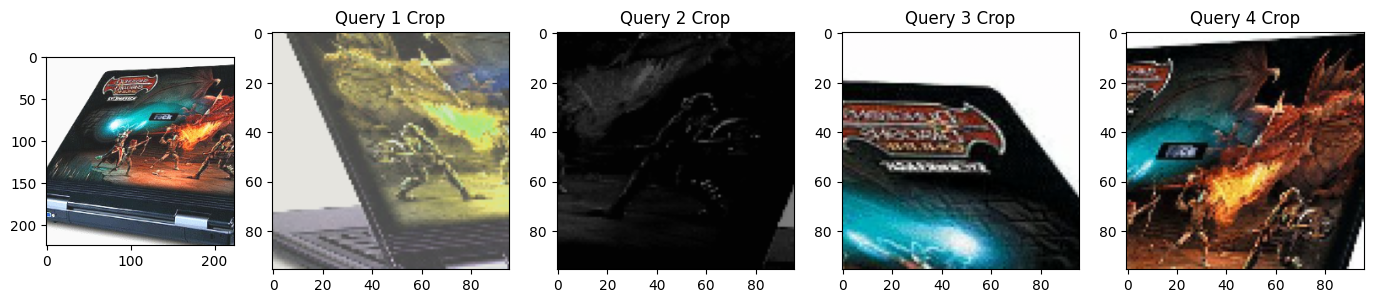

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from configs.loca_imnet1k_base16 import MEAN_RGB, STDDEV_RGB

viz_batch = next(dataset.train_iter)
viz_batch = remove_batch_dim0(viz_batch)
viz_batch = utils.prepare_input(viz_batch, config)

fig = plt.figure(figsize=(17, 9))

gs0 = gridspec.GridSpec(2, 6, figure=fig)

# Plot reference
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[:2, :2])
ref_img = (viz_batch['reference'][0] * jnp.array(STDDEV_RGB) + jnp.array(MEAN_RGB))
ax1.imshow(ref_img)

# Plot queries
n_q_foc = config.dataset_configs.number_of_focal_queries
queries = viz_batch['queries'].reshape(n_q_foc, config.batch_size, 96, 96, 3)
gs01 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs0[1:])
for i, query in enumerate(queries[:4]):
    ax = fig.add_subplot(gs01[0, i])
    ax.imshow(query[0] * jnp.array(STDDEV_RGB) + jnp.array(MEAN_RGB))
    ax.set_title(f'Query {i + 1} Crop')

## Load Model

In [ ]:
import flax
from flax.training import checkpoints
import optax
from scenic.train_lib import lr_schedules
import vit
import copy

model = vit.ViTLOCAModel(config, dataset.meta_data)

rng, init_rng = jax.random.split(rng)
(params, _, num_trainable_params, gflops) = train_utils.initialize_model(
    model_def=model.flax_model,
    input_spec=[
        (dataset.meta_data['input_shape'], dataset.meta_data.get('input_dtype', jnp.float32))],
    config=config, rngs=init_rng
)

# Only one model function but two sets of parameters.
ema_params = copy.deepcopy(params)

learning_rate_fn = lr_schedules.get_learning_rate_fn(config)
momentum_parameter_scheduler = lr_schedules.compound_lr_scheduler(
  config.momentum_rate)

weight_decay_mask = jax.tree_util.tree_map(lambda x: x.ndim != 1, params)
tx = optax.inject_hyperparams(optax.adamw)(
  learning_rate=learning_rate_fn, weight_decay=config.weight_decay,
  mask=weight_decay_mask)

opt_state = jax.jit(tx.init, backend='cpu')(params)

chrono = train_utils.Chrono()

train_state = utils.TrainState(
  global_step=0, opt_state=opt_state, tx=tx, params=params,
  ema_params=ema_params, rng=rng, metadata={'chrono': chrono.save()})

checkpoint_path = "/home/admin/john/scenic/loca_tiny/checkpoint_144001"
train_state = checkpoints.restore_checkpoint(checkpoint_path, train_state)

## Run Inference

In [ ]:
batch = next(dataset.train_iter)

batch = remove_batch_dim0(batch, debug=True)
batch = utils.prepare_input(batch, config)

In [ ]:
dropout_rng, droptok_rng = jax.random.split(rng)

use_ema = True
drop_moment = "late"

_, r_feat_targets, r_patch_features, _  = model.flax_model.apply(
    {'params': train_state.ema_params if use_ema else params},
    batch['reference'],
    seqlen=config.reference_seqlen,
    seqlen_selection=config.reference_seqlen_selection,
    drop_moment=drop_moment,
    train=True,
    rngs={'dropout': dropout_rng, 'droptok': droptok_rng}
)

In [ ]:
use_pe = False

q_rand_loc_pred, q_rand_feat_pred, q_rand_patches, q_rand_idx_kept = model.flax_model.apply(
    {'params': params},
    batch['query0'],
    inputs_kv=r_patch_features,
    seqlen=config.query_max_seqlen,
    use_pe=use_pe,
    train=True,
    rngs={'dropout': dropout_rng, 'droptok': droptok_rng})

In [ ]:
n_q_foc = config.dataset_configs.number_of_focal_queries

q_foc_loc_pred, q_foc_feat_pred, _, _ = model.flax_model.apply(
    {'params': params},
    batch['queries'],
    inputs_kv=jnp.tile(r_patch_features, (n_q_foc, 1, 1)),
    use_pe=use_pe,
    train=True,
    rngs={'dropout': dropout_rng})

## Analyse model output

### Reference patch tokens

In [ ]:
print(r_patch_features.shape)
r_patch_features[0, ::10, :4]

### Query-rand patch tokens

In [ ]:
print(q_rand_patches.shape)
q_rand_patches[:2, ::10, :4]

### `Q_rand` location targets

In [ ]:
q_rand_targets = batch["query0_target_position"]
print(q_rand_targets[0].squeeze(-1))

In [ ]:
q_rand_loc_targets = batch['query0_target_position'].reshape(config.batch_size, -1)
q_rand_loc_targets = jnp.take(q_rand_loc_targets, q_rand_idx_kept, axis=1)
q_rand_loc_targets[0][q_rand_loc_targets[0] != -1]

### `q_rand` location predictions

In [ ]:
print("q_rand_loc_pred", q_rand_loc_pred.shape)

q_rand_loc_pred[0].argmax(axis=1)